# Imports

In [112]:
!pip install numpy pandas matplotlib plotly scipy scikit-image scikit-learn torch torchvision kagglehub
!pip install nbformat

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import kagglehub
import os

In [114]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
pmem = True if device == "cuda" else False
print(device)

mps


In [115]:
transform = transforms.Compose([transforms.ToTensor()])
images = torchvision.datasets.ImageFolder("coil-20-proc", transform=transform)
print(images.classes)
train_images = DataLoader(images, batch_size=72, shuffle=True, pin_memory=pmem)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']


In [116]:
def label_string(label_int):
    match label_int:
        case 0:
            return "duck"
        case 1:
            return "block toy"
        case 2:
            return "toy racecar"
        case 3:
            return "waving cat"
        case 4:
            return "anacin box"
        case 5:
            return "toy convertible"
        case 6:
            return "block toy 2"
        case 7:
            return "baby powder"
        case 8:
            return "tylenol"
        case 9:
            return "vaseline"
        case 10:
            return "block toy (semicircle)"
        case 11:
            return "cup"
        case 12:
            return "piggy bank"
        case 13:
            return "valve"
        case 14:
            return "bucket"
        case 15:
            return "conditioner bottle"
        case 16:
            return "pot"
        case 17:
            return "teacup"
        case 18:
            return "toy convertible (lame)"
        case 19:
            return "cream cheese tub"
        case _:
            return "none of the above"

In [117]:
train_images

In [298]:
model = nn.Sequential()
model.add_module(
    'conv1',
    nn.Conv2d(
        in_channels=3,out_channels=32,
        kernel_size=5,padding=2
    )
)
model.add_module('relu1',nn.ReLU())
model.add_module('pool1',nn.MaxPool2d(kernel_size=2))

model.add_module(
    'conv2',
    nn.Conv2d(
        in_channels=32, out_channels=64,
        kernel_size=5,padding=2
    )
)
model.add_module('relu2',nn.ReLU())
model.add_module('pool2',nn.MaxPool2d(kernel_size=2))

#### experiment
model.add_module(
    'conv3',
    nn.Conv2d(
        in_channels=64, out_channels=128,
        kernel_size=5, padding=2
    )
)
model.add_module('relu3', nn.ReLU())
model.add_module('pool3',nn.MaxPool2d(kernel_size=2))

model.add_module(
    'conv4',
    nn.Conv2d(
        in_channels=128, out_channels=256,
        kernel_size=8, padding=4
    )
)
model.add_module('relu4', nn.ReLU())
model.add_module('pool4',nn.MaxPool2d(kernel_size=2))

model.add_module(
    'conv5',
    nn.Conv2d(
        in_channels=256, out_channels=512,
        kernel_size=8, padding=4
    )
)
model.add_module('relu5', nn.ReLU())
model.add_module('pool5',nn.MaxPool2d(kernel_size=2))
######

model.add_module('flatten',nn.Flatten())

x = torch.ones((4,3,128,128))
dims = model(x).shape

model.add_module('fc1',nn.Linear(dims[1], 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout',nn.Dropout(p=0.5))
model.add_module('fc2',nn.Linear(1024,20))
model.to(device)

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(8, 8), stride=(1, 1), padding=(4, 4))
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(8, 8), stride=(1, 1), padding=(4, 4))
  (relu5): ReLU()
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8192,

In [299]:
num_epochs = 5

loss_history_train = np.zeros(num_epochs)
accuracy_history_train = np.zeros(num_epochs)
loss_history_valid = np.zeros(num_epochs)
accuracy_history_valid = np.zeros(num_epochs)

In [300]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_images:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        loss_history_train[epoch] += loss.item()*y_batch.size(0)
        accuracy_history_valid[epoch] += is_correct.sum()
    
    model.eval()
    print(epoch)


0
1


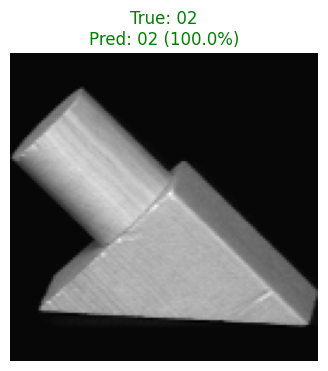

In [ ]:
img_tensor, label = images[73]
input_tensor = img_tensor.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    logits = model(input_tensor)
    probs = F.softmax(logits, dim=1)
    confidence, pred_label = torch.max(probs,1)

    predicted_class = images.classes[pred_label.item()]
    true_class = images.classes[label]
    conf_score = confidence.item()

    plt.figure(figsize=(4,4))
    plt.imshow(img_tensor.permute(1,2,0))
    title_color = 'green' if predicted_class == true_class else 'red'
    plt.title(f"True: {true_class}\nPred: {predicted_class} ({conf_score:.1%})", color=title_color)
    plt.axis('off')
    plt.show()

In [ ]:
count_correct = 0
incorrect = []
for i in range(1440):
    img_tensor, label = images[i]
    input_tensor = img_tensor.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)
        probs = F.softmax(logits, dim=1)
        confidence, pred_label = torch.max(probs,1)

        predicted_class = images.classes[pred_label.item()]
        true_class = images.classes[label]
        conf_score = confidence.item()
        if predicted_class == true_class:
            count_correct += 1
        else:
            incorrect.append(i)


In [ ]:
def display_image_tensor(img_tensor):
    plt.figure(figsize=(4,4))
    plt.imshow(img_tensor.permute(1,2,0))
    plt.axis('off')
    plt.show()
    

In [ ]:
count_correct

1440

In [ ]:
count_correct/1440

1.0

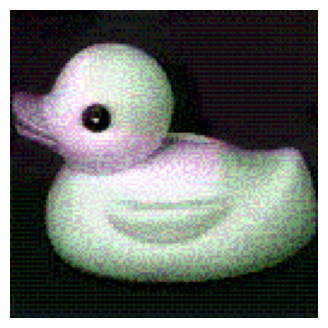

In [ ]:
# Attack
start_image_tensor, true_label = images[0]
start_image = start_image_tensor.unsqueeze(0).to(device)
true_label = torch.Tensor([true_label]).to(device)

start_image.requires_grad = True

output = model(start_image)
init_pred = output.max(1,keepdim=True)[1]

loss = F.nll_loss(output, true_label)
model.zero_grad()
loss.backward()
image_grad = start_image.grad.data
sign_image_grad = image_grad.sign()
perturbed_image = start_image + 0.1*sign_image_grad
perturbed_image = torch.clamp(perturbed_image,0,1).squeeze(0)
perturbed_image_disp = perturbed_image.cpu().detach()
display_image_tensor(perturbed_image_disp)

In [ ]:
def attack(image_index, delta, n):
    # Attack
    #perturbed_image_disp = perturbed_image.cpu().detach()
    #display_image_tensor(perturbed_image_disp)
    image_tensor, label = images[image_index]
    start_image = image_tensor.unsqueeze(0).to(device)
    label = torch.Tensor([label]).to(device)
    start_image.requires_grad = True
    for i in range(n):

        start_image.requires_grad = True

        output = model(start_image)
        init_pred = output.max(1, keepdim=True)[1]

        loss = F.nll_loss(output, true_label)
        model.zero_grad()
        loss.backward()

        image_grad = start_image.grad.data
        #grad_sign = torch.sign(image_grad)
        perturbed_image = start_image + delta*image_grad
        #perturbed_image = start_image + delta*grad_sign
        perturbed_image = torch.clamp(perturbed_image,0,1)

        output_pert = model(perturbed_image)

        pert_pred = output_pert.max(1,keepdim=True)[1]
        probs_init = F.softmax(output, dim=1)
        probs_pert = F.softmax(output_pert, dim=1)

        confidence_init, pred_label_init = torch.max(probs_init,1)
        conf_init_float = float(confidence_init.detach())
        pred_init_int = int(pred_label_init.detach())

        confidence_pert, pred_label_pert = torch.max(probs_pert,1)
        conf_pert_float = float(confidence_pert.detach())
        pred_pert_int = int(pred_label_pert.detach())
        #print("init_pred: {}, with confidence: {:f}".format(label_string(pred_init_int), conf_init_float))
        print("pred: {}, with confidence: {:f}".format(label_string(pred_pert_int), conf_pert_float))
        if init_pred != pert_pred:
            break
        start_image = perturbed_image.detach()

    return start_image.squeeze(0).cpu().detach()

pred: duck, with confidence: 0.999995
pred: duck, with confidence: 0.999980
pred: duck, with confidence: 0.999931
pred: duck, with confidence: 0.999762
pred: duck, with confidence: 0.999169
pred: duck, with confidence: 0.996906
pred: duck, with confidence: 0.986823
pred: duck, with confidence: 0.927373
pred: duck, with confidence: 0.574180
pred: anacin box, with confidence: 0.786351


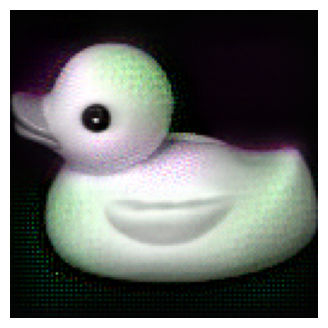

In [ ]:
image_attack = attack(0, 1,200)
display_image_tensor(image_attack)

In [ ]:
ducks = torchvision.datasets.ImageFolder("ducks", transform=transform)

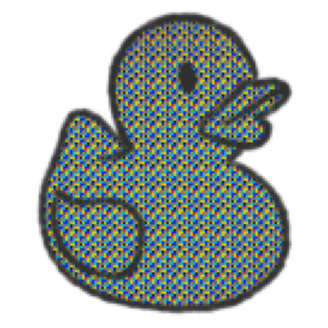

In [ ]:
my_duck,_ = ducks[3]
display_image_tensor(my_duck)
my_duck = my_duck.unsqueeze(0).to(device)
my_output = model(my_duck)
probs = F.softmax(my_output, dim=1)
confidence, pred_label = torch.max(probs,1)

In [ ]:
float(confidence.detach())

0.975338339805603

In [ ]:
pred_label

tensor([16], device='mps:0')